# Credit Default Predictor

###### Data from UC Irvine 

In [2]:
!pip install shap

## Table of contents
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Summary of the results](#13)

<!-- BEGIN QUESTION -->

## Imports

<div class="alert alert-warning">
    
Imports
    
</div>

_Points:_ 0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from hashlib import sha1
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer

## 1. Prediction Problem <a name="1"></a>
<hr>

#### Overview of Problem
This is a classification problem to predict whether a credit card client will default or not. The data has been taken from the [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. 

#### Dataset Variables

The problem that the dataset presents is predicting whether or not Taiwanese clients will have a credit card default (when a client has failed to pay their debt for a certain period) from April to September 2005. In the dataset, there is a total number of 25 parameters including the "target" parameter. The parameters are listed below:

- ID
    * Unique identifier for each client
- LIMIT_BAL
    * Total credit limit (NT dollars) including individual and supplementary family credit
- SEX
    * Gender (1 = male; 2 = female)
- EDUCATION
    * Education level (1 = graduate school; 2 = university; 3 = high school; 4 = others)
- MARRIAGE
    * Marital status (1 = married; 2 = single; 3 = others)
- AGE
    * Client's age in years
- PAY_0 - PAY_6 (In total 7 parameters)
    * Repayment status (April-September 2005), scaled from -1 (paid duly) to 9 (9+ months delayed)
        * PAY_0 = September 2005 repayment status
        * ...
        * PAY_6 = April 2005 repayment status
- BILL_AMT1 - BILL_AMT6 (In total 7 parameters)
    * Amount of bill statement (NT dollar)
        * BILL_AMT1 = September 2005 bill amount
        * ...
        * BILL_AMT6 = April 2005 bill amount
- PAY_AMT1 - PAY_AMT6 (In total 7 parameters)
    * Amount of previous payment (NT dollar)
        * PAY_AMT1 = Amount paid in September 2005
        * ...
        * PAY_AMT6 = Amount paid in April 2005
- default.payment.next.month ("Target")
    * (Binary) Indicates whether a client defaulted (1) or not (0) in the next month (October 2005)

#### Current Considerations

To figure out in Taiwan (in the year of 2005) whether a client will get a credit card default may not be reliant on some of the mentioned parameters. Features such as 'ID', 'Sex', 'Education', 'Marriage', and 'Age' may have little impact on determining this target (This will be later explored in the EDA section). 

Main features that will contribute to the target are likely to be 'LIMIT_BAL', "PAY_0", ... "PAY_6", "BILL_ATM1", ..., "BILL_ATM6", and "PAY_ATM1", ..., "PAY_ATM6". However, before these features are selected, EDA will be performed first to validate our decision. Another consideration is that this data would probably not generalize to the current landscape today in Taiwan given that this dataset is from 2005 (20 year old dataset). However, credit behaviour exhibited from this dataset may be apparent in today's world scape. 

In [4]:
#Downloading the dataset and reading it as a pandas dataframe 

df = pd.read_csv("data/UCI_Credit_Card.csv")

#Renaming the target feature for convinience
df = df.rename(columns={"default.payment.next.month" : "default"}) 

#Without this line, we will have to ID columns in the dataframe
df = df.drop(columns=['ID'])

In [5]:
df['default'].value_counts()

default
0    23364
1     6636
Name: count, dtype: int64

## 2. Data splitting <a name="2"></a>
<hr>

The data will be split into a training (70%) and testing (30%) portion with `random_state=123`.

<div class="alert alert-warning">
    
Solution_2
    
</div>

_Points:_ 2

In [6]:
X = df.drop(columns=["default"])
y = pd.DataFrame(df["default"])

In [7]:
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2,2,2,26,-1,2,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2,2,2,34,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2,2,1,37,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


In [8]:
y.head()

,default
0,1
1,1
2,0
3,0
4,0


In [9]:
#Splitting the data into train (70%) and test (30%) portions with `random_state=123`

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [10]:
y_train.value_counts()

default
0          16312
1           4688
Name: count, dtype: int64

<!-- END QUESTION -->

<br><br>

## 3. EDA <a name="3"></a>
<hr>

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

#### Exploratory Data Analysis on Training Set

In [ ]:
# Splitting features by type for EDA
features = X_train.columns.to_list()
numeric_features = ['LIMIT_BAL', 'AGE', 
                    'BILL_AMT1', 'BILL_AMT2', 
                    'BILL_AMT3', 'BILL_AMT4', 
                    'BILL_AMT5', 'BILL_AMT6',
                    'PAY_AMT1', 'PAY_AMT2',
                    'PAY_AMT3', 'PAY_AMT4',
                    'PAY_AMT5', 'PAY_AMT6']

non_numeric_features = list(set(features) - set(numeric_features))

# Concatting X_train & y_train to use for EDA
df_train = pd.concat([X_train, y_train], axis=1)


#### Summary Statistics (default, BILL_ATM, PAY_ATM, and PAY features)

##### default (Target Class)

In [12]:
# 2. Include at least two summary statistics, and accompany each one with a sentence explaining it.
df_train['default'].value_counts()

default
0    16312
1     4688
Name: count, dtype: int64

In the training set, 77.7% of the examples did not default on their credit card payments, while 23.3% did. This indicates a class imbalance, which may lead to biased predictions if not addressed — for instance, the classifier might favor the majority class (non-default) during training.

##### BILL_AMT (Bill Amount)

In [13]:
# 2. Include at least two summary statistics, and accompany each one with a sentence explaining it.

bill_summary = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()
bill_summary_df = pd.DataFrame(bill_summary.loc['mean':'std'])
bill_summary_df

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
mean,51107.566762,49126.824810,47010.414095,43486.610905,40428.518333,38767.202667
std,73444.143025,71400.032096,69035.759516,64843.303993,61187.200817,59587.689549


From September to April 2005 (descending order), standard deviation of a client's bill amount are much larger than the mean payment meaning that this feature is most-likely skewed to the right (their are outliers with really high bills causing this gap between the summary statistic and standard deviation).

#### PAY_ (Repayment Status)

In [14]:
# 2. Include at least two summary statistics, and accompany each one with a sentence explaining it.

bill_summary = X_train[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mode()
bill_summary

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,0,0,0,0,0,0


The most frequent repayment status across PAY_0 to PAY_6 is 0, indicating that the majority of customers consistently used revolving credit without falling behind on payments. This suggests that while many cardholders carry a balance from month to month, they generally avoid becoming delinquent. However, it also implies that full payments (-1) are less common, and actual payment delays (1 or higher) are not the norm for most users.

From September to April 2005 (descending order), the mode is '0'. This denotes that majority of Taiwanese clients paid at least the minimum amount due on time.

#### PAY_AMT (Payment Amount)

In [15]:
# 2. Include at least two summary statistics, and accompany each one with a sentence explaining it.

bill_summary = X_train[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()
bill_summary_df = pd.DataFrame(bill_summary.loc['mean':'std'])
bill_summary_df

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
mean,5673.585143,5895.026905,5311.432286,4774.021381,4751.850095,5237.762190
std,17033.241454,21801.431148,18377.997079,15434.136142,15228.193125,18116.846563


From September to April 2005 (descending order), standard deviation of the clients payments to their bills are much larger than the mean payment meaning that this feature is most-likely skewed to the right (their are outliers with really high payments causing this gap between the summary statistic and standard deviation).

### Visualiazation - Numeric Features

/var/folders/kz/3t7pyllj7w3fy7h055vlb0p00000gn/T/ipykernel_13543/2891682182.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(data,
/var/folders/kz/3t7pyllj7w3fy7h055vlb0p00000gn/T/ipykernel_13543/2891682182.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(data,


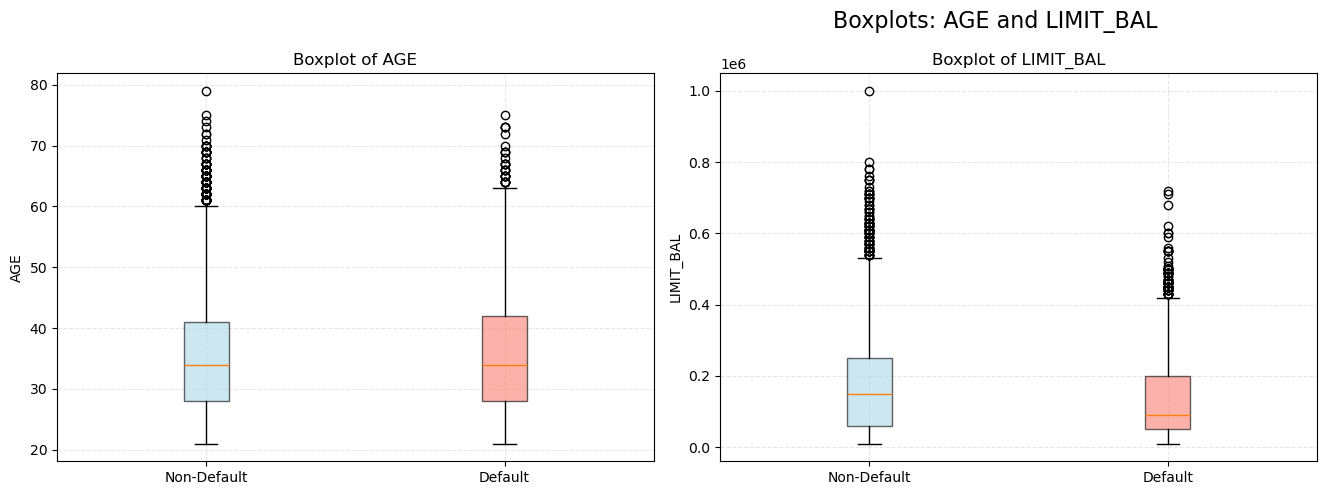

/var/folders/kz/3t7pyllj7w3fy7h055vlb0p00000gn/T/ipykernel_13543/2891682182.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(data,
/var/folders/kz/3t7pyllj7w3fy7h055vlb0p00000gn/T/ipykernel_13543/2891682182.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(data,
/var/folders/kz/3t7pyllj7w3fy7h055vlb0p00000gn/T/ipykernel_13543/2891682182.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[i].boxplot(data,
/var/folders/kz/3t7pyllj7w3fy7h055vlb0p00000gn/T/ipykernel_13543/2891682182.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has b

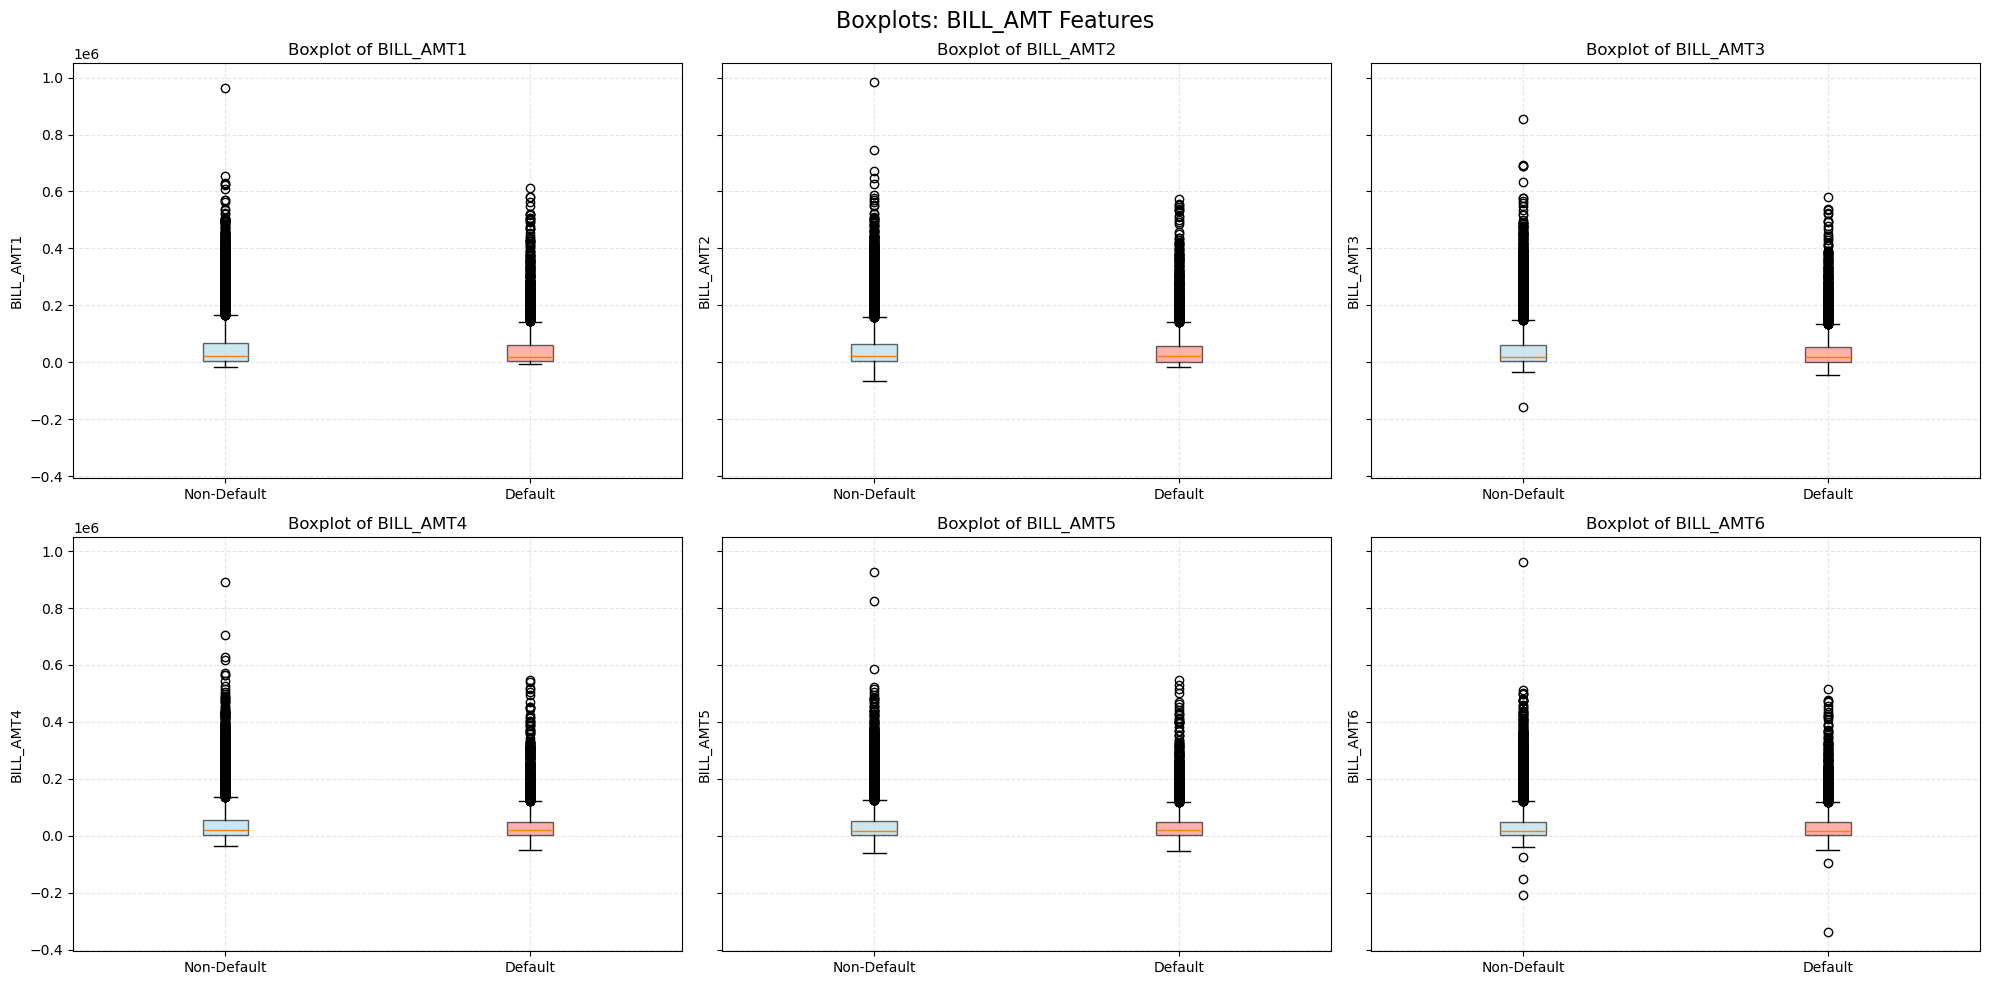

In [16]:
# 2. Include at least two visualizations, and accompany each one with a sentence explaining it.


# Group 1: AGE and LIMIT_BAL
group1_features = ['AGE', 'LIMIT_BAL']

# Group 2: All BILL_AMT features
group2_features = [feat for feat in numeric_features if 'BILL_AMT' in feat]

def plot_boxplots(features, group_name, share_y_axis):
    cols_per_row = 3
    n_rows = math.ceil(len(features) / cols_per_row)
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(20, 5*n_rows), sharey = share_y_axis)
    axes = axes.flatten()

    for i, feat in enumerate(features):
        data = [group[feat] for _, group in df_train.groupby('default')]
        box = axes[i].boxplot(data,
                              patch_artist=True,
                              labels=['Non-Default', 'Default'])

        colors = ['lightblue', 'salmon']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)

        axes[i].set_title(f'Boxplot of {feat}')
        axes[i].set_ylabel(feat)
        axes[i].grid(True, linestyle='--', alpha=0.3)

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(f'{group_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot each group
plot_boxplots(group1_features, "Boxplots: AGE and LIMIT_BAL", False)
plot_boxplots(group2_features, "Boxplots: BILL_AMT Features", True)


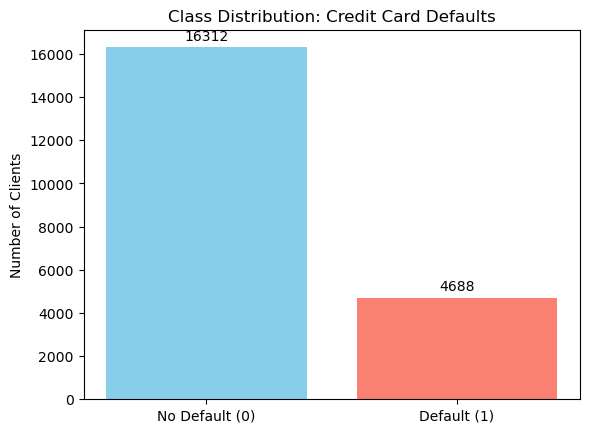

In [75]:
import matplotlib.pyplot as plt

# Count the number of positive (1) and negative (0) cases
class_counts = y_train.value_counts().sort_index()

# Define labels and counts
labels = ['No Default (0)', 'Default (1)']
counts = [class_counts[0], class_counts[1]]

# Plot
plt.bar(labels, counts, color=['skyblue', 'salmon'])
plt.ylabel('Number of Clients')
plt.title('Class Distribution: Credit Card Defaults')

# Optional: Show value labels on top
for i, count in enumerate(counts):
    plt.text(i, count + 200, str(count), ha='center', va='bottom')

plt.show()


For the first set of box-plots, the features AGE & LIMIT_BAL (limit balance) are skewed to the right for both classes. Although the shape of the distribution is roughly the same for both classes, for age, the range for the default class is larger than non-default (not taking into account the outliers). For LIMIT_BAL, the range of the non-default class is greater than the default class. Lastly, there are more outliers in the non-default class because of the class imbalance leaning towards the negative class.

For the second set of box-plots, this grid of boxplots compares the distribution of credit card bill amounts (BILL_AMT1 to BILL_AMT6) between clients who defaulted (red) and those who did not (blue), revealing similarity in median spending, variability. The only apparent difference between the classes for these features revolves around that the non-default class tends to have more extreme outliers than the default class. It is also worth noting that the data is skewed to the right.

### Visualiazation - Categorical/Ordinal Features

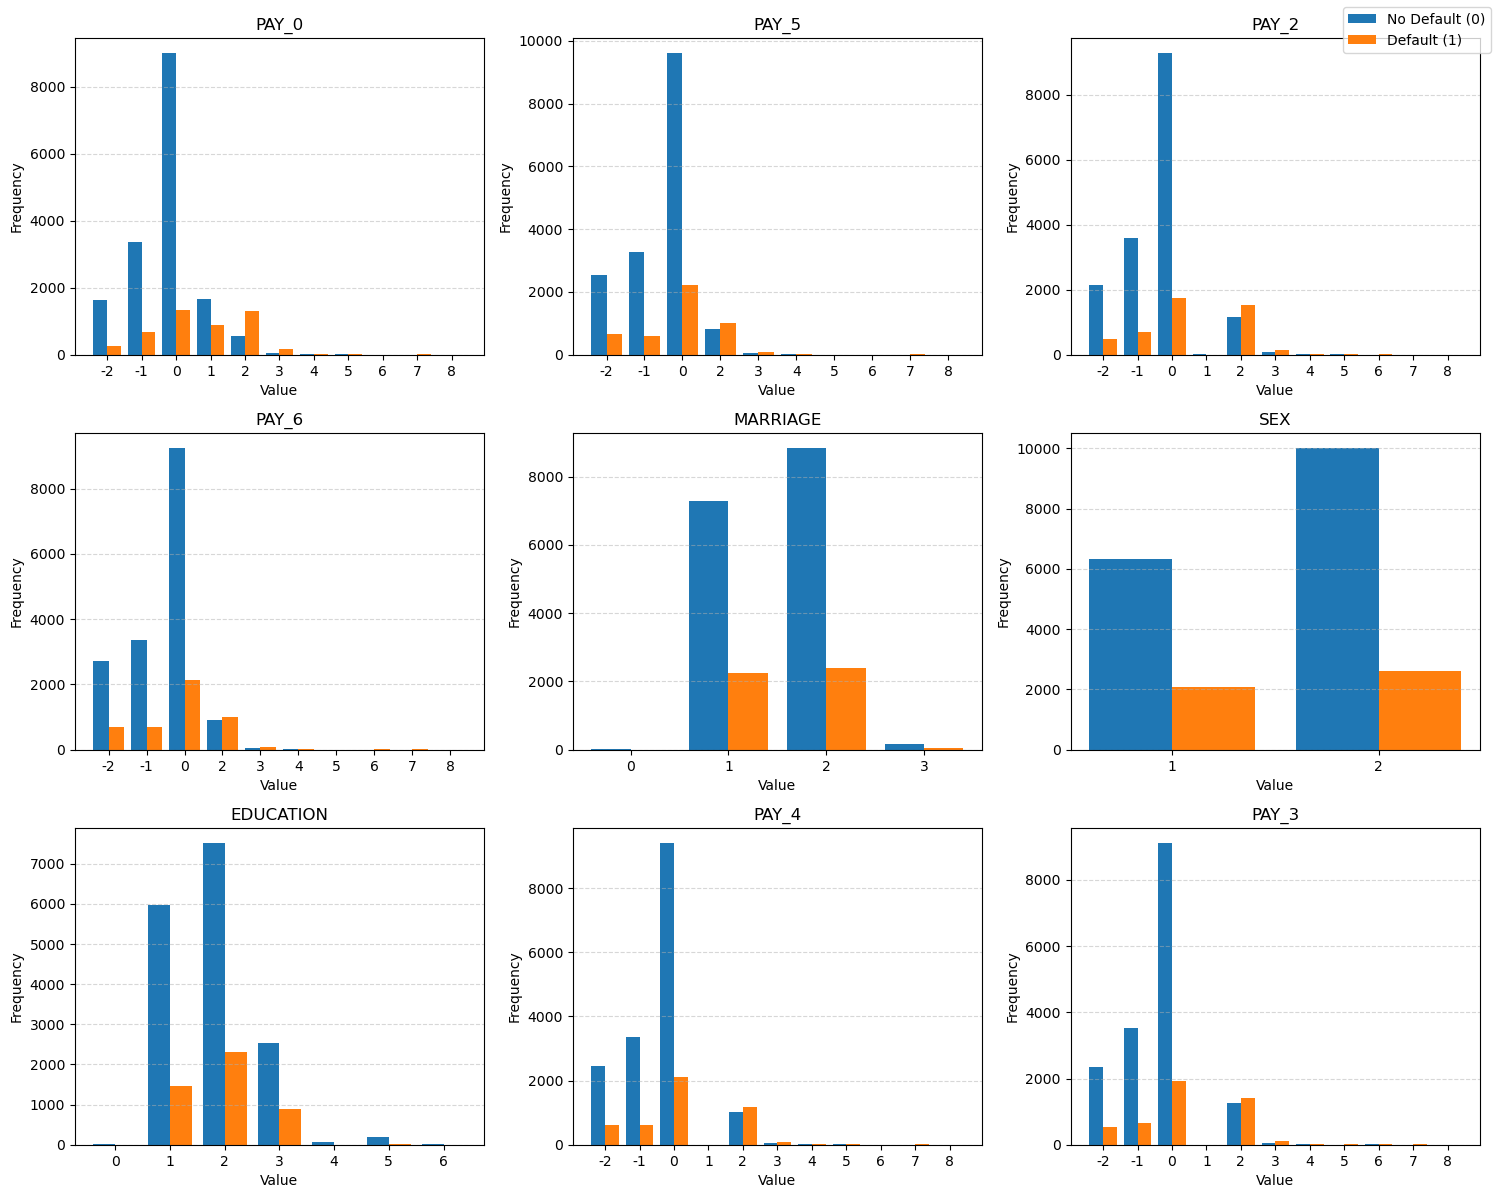

In [ ]:
def plot_categorical_grid(df, target_col='default'):

    # Set up the grid
    num_features = len(non_numeric_features)
    n_cols = 3
    n_rows = int(np.ceil(num_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  # Flatten for easy iteration

    for idx, feature in enumerate(non_numeric_features):
        ax = axes[idx]

        # Cross-tab (frequency table) grouped by target
        ctab = pd.crosstab(df[feature], df[target_col]).sort_index()

        # Ensure both target classes are present
        for cls in [0, 1]:
            if cls not in ctab.columns:
                ctab[cls] = 0
        ctab = ctab[[0, 1]]

        x = np.arange(len(ctab.index))
        bar_width = 0.4

        ax.bar(x - bar_width/2, ctab[0], width=bar_width, label='No Default (0)')
        ax.bar(x + bar_width/2, ctab[1], width=bar_width, label='Default (1)')

        ax.set_xticks(x)
        ax.set_xticklabels(ctab.index.astype(str), rotation=0)
        ax.set_title(f'{feature}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Hide unused axes if any
    for i in range(len(non_numeric_features), len(axes)):
        fig.delaxes(axes[i])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    plt.tight_layout()
    plt.show()

plot_categorical_grid(df_train)

2. For all the categorical & ordinal features graphed in a histogram, although each class 0's frequency is drastically higher than class 1's, they generally follow the same shape. This is clear for the features such as 'Education', 'Sex', and 'Marriage'. However, when we look at the 'Pay' variables (denoting their delays in payment), it appears that when the value is two (when clients' payment are delayed for more than two months) class 1's frequency is higher than class 0's frequency.

#### Summary of Observations

3. The numeric continuous features in the dataset appear to be right-skewed, indicating the presence of outliers or a long tail of higher values. Although the distributions of these features show similar shapes across both default and non-default classes, feature engineering—such as combining 'BILL_AMT' and 'PAY_AMT' to compute payment ratios or trends—may yield more predictive features for classifying credit card default. For the categorical and ordinal features, such as 'Education', 'Sex', and 'Marriage', the class distributions are relatively similar, suggesting limited discriminative power. However, the 'PAY_0' to 'PAY_6' variables, which reflect repayment status, show a notable pattern: when payment is delayed by two months or more, the proportion of defaults (class 1) becomes higher than non-defaults (class 0). This suggests that extended payment delays are a strong indicator of credit risk and could be valuable features in classification.

#### Metrics for Assessment

4. Given the imbalance in the target classes (with default = 1 making up ~23% of the training data), accuracy alone is not an appropriate metric, as it would overestimate model performance. Instead, we recommend using the F1 score, as it balances precision and recall and is better suited for imbalanced classification problems. Additionally, we could monitor recall if missing true defaults is especially costly (e.g., in financial risk settings).


## 4. Feature engineering <a name="4"></a>
<hr>

#### Creating New Features & Scaling

For creating new features, perhaps combining the features 'BILL_AMT' and 'PAY_AMT' into a ratio may be optimal. Thus, there would have a new feature called 'PAY_BILL_RATIO' for each month September to April 2005 (with values between 0 and 1) - calculated as 'BILL_AMT'/'PAY_AMT'. Furthermore, given that the distribution for the data in numerical features is skewed to the right, it may be beneficial to apply logarithmic scaling. This scaling may help with model training later on.

Additionally, it may help to create a 'TOTAL_BILL' feature that sums up all the 'BILL_AMT' into a singular value. This feature would then be used to create another feature called 'UTIL_RATE' denoting the utilization rate calculated by 'TOTAL_BILL'/'LIMIT_BAL'.

Lastly, we will create another feature called 'NUM_LATE_PAYMENTS' that just counts how many times a client has made a late payment in the specified time period.

New Features:
- PAY_BILL_RATIO (BILL_AMT'/'PAY_AMT)
- UTIL_RATE ('TOTAL_BILL'/'LIMIT_BAL')
- NUM_LATE_PAYMENTS (Counting the number of late payments made)

#### Dropping Features

Given the similar distribution shape of the 'Education', 'Sex', and 'Marriage' feature among the classes, we think it may be optimal to drop these features for this classifcation problem. Because they do not have different distributions among classes, they may not be helpful in this problem. 

Also because the new features we proposed to create involve aggregations of other numerical features, we will drop those ones. So this would be the BILL_AMTx and PAY_AMTx features, but we will still keep UTIL_RATE.

However, it may be the case that these dropped features will be brought back if they can actually help the classifier model after further analysis. 

Dropped Features (so far):
- BILL_AMTx
- PAY_AMTx
- Education
- Sex
- Marriage

<em> Future Note: After going with our decision to use certain features and run it on different models, another preprocessor was created that included the dropped features such as Education (ordinal-ranking), Sex (one-hot-encoding) and Marriage (one-hot-encoding). Results showed that the model's performance did not improve, and feature analysis showed that these dropped features were trivial to the classification process (so we did not proceed with these features).  </em>

#### Coding New Features

In [ ]:
# Creating new features
from sklearn.base import BaseEstimator, TransformerMixin

class CreditFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]
        self.pay_amt_cols = [f'PAY_AMT{i}' for i in range(1, 7)]
        self.pay_status_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

    def fit(self, X, y=None):
        return self  # nothing to fit

    def transform(self, X):
        X = X.copy()

        # Total bill and pay
        X['TOTAL_BILL'] = X[self.bill_cols].sum(axis=1)
        X['TOTAL_PAY'] = X[self.pay_amt_cols].sum(axis=1)

        # PAY_BILL_RATIO (with protection against division by zero)
        X['PAY_BILL_RATIO'] = X['TOTAL_PAY'] / X['TOTAL_BILL'].replace(0, 1)

        # UTIL_RATE
        X['UTIL_RATE'] = X['TOTAL_BILL'] / X['LIMIT_BAL'].replace(0, 1)

        # NUM_LATE_PAYMENTS
        X['NUM_LATE_PAYMENTS'] = X[self.pay_status_cols].gt(0).sum(axis=1)

        return X

#Ensure there are no issues when applying log in preprocessing step
def clip_log_features(X):
    """
    Clips negative values in log-scaled features to avoid issues with log transform.
    Applies in-place and returns a modified copy of the input DataFrame.
    """
    X = X.copy()

    log_features = ['TOTAL_BILL', 'TOTAL_PAY', 'PAY_BILL_RATIO', 'UTIL_RATE']
    
    for feat in log_features:
        if feat in X.columns:
            X[feat] = X[feat].apply(lambda x: max(x, 1e-3))  # Prevents log(0) or log of negative

    return X

In [19]:
engineer = CreditFeatureEngineer()
X_train_new = clip_log_features(engineer.fit_transform(X_train))
X_test_new = clip_log_features(engineer.transform(X_test))

In [20]:
X_train_new

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,TOTAL_BILL,TOTAL_PAY,PAY_BILL_RATIO,UTIL_RATE,NUM_LATE_PAYMENTS
16395,320000.0,2,1,2,36,0,0,0,0,0,...,5018.0,1000.0,3000.0,0.0,7013.0,119213.000,21031.000,0.176415,0.372541,0
21448,440000.0,2,1,2,30,-1,-1,-1,0,0,...,87426.0,130007.0,3018.0,15000.0,51663.0,528826.000,287726.000,0.544084,1.201877,0
20034,160000.0,2,3,1,44,-2,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.001,0.001,0.001000,0.001000,0
25755,120000.0,2,2,1,30,0,0,0,0,0,...,5502.0,4204.0,3017.0,2005.0,1702.0,530682.000,20136.000,0.037944,4.422350,0
1438,50000.0,1,2,2,54,1,2,0,0,0,...,1400.0,1200.0,1500.0,1000.0,1500.0,205081.000,6600.000,0.032182,4.101620,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28636,380000.0,2,2,1,37,0,0,0,0,0,...,1300.0,1242.0,1900.0,0.0,3000.0,86869.000,8646.000,0.099529,0.228603,1
17730,360000.0,2,1,1,54,1,-2,-2,-1,0,...,0.0,2580.0,0.0,6941.0,0.0,12101.000,9521.000,0.786794,0.033614,1
28030,50000.0,2,3,1,29,0,0,0,0,0,...,2000.0,1530.0,1000.0,327.0,329.0,199605.000,7188.000,0.036011,3.992100,0
15725,30000.0,2,2,2,21,0,0,0,0,0,...,2000.0,2000.0,1765.0,331.0,0.0,163214.000,8096.000,0.049604,5.440467,0


In [21]:
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
16395,320000.0,2,1,2,36,0,0,0,0,0,...,28695.0,19370.0,10155.0,3788.0,5000.0,5018.0,1000.0,3000.0,0.0,7013.0
21448,440000.0,2,1,2,30,-1,-1,-1,0,0,...,87426.0,171244.0,150897.0,117870.0,612.0,87426.0,130007.0,3018.0,15000.0,51663.0
20034,160000.0,2,3,1,44,-2,-2,-2,-2,-2,...,-18.0,-18.0,-18.0,-18.0,0.0,0.0,0.0,0.0,0.0,0.0
25755,120000.0,2,2,1,30,0,0,0,0,0,...,104694.0,103058.0,71095.0,47379.0,3706.0,5502.0,4204.0,3017.0,2005.0,1702.0
1438,50000.0,1,2,2,54,1,2,0,0,0,...,27168.0,27585.0,27910.0,27380.0,0.0,1400.0,1200.0,1500.0,1000.0,1500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28636,380000.0,2,2,1,37,0,0,0,0,0,...,13277.0,14291.0,15949.0,15556.0,1204.0,1300.0,1242.0,1900.0,0.0,3000.0
17730,360000.0,2,1,1,54,1,-2,-2,-1,0,...,0.0,2580.0,2580.0,6941.0,0.0,0.0,2580.0,0.0,6941.0,0.0
28030,50000.0,2,3,1,29,0,0,0,0,0,...,46777.0,39420.0,8824.0,9009.0,2002.0,2000.0,1530.0,1000.0,327.0,329.0
15725,30000.0,2,2,2,21,0,0,0,0,0,...,29435.0,30841.0,29434.0,16565.0,2000.0,2000.0,2000.0,1765.0,331.0,0.0


<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations <a name="5"></a>
<hr>

#### Identifying New Features

In [22]:
# Features
features = list(X_train_new.columns)

In [23]:
# Identifying different feature types and the transformations you would apply on each feature type. 

numeric_features = ['LIMIT_BAL', 'TOTAL_BILL', 'TOTAL_PAY', 'PAY_BILL_RATIO', 'UTIL_RATE']
ordinal_features = ['NUM_LATE_PAYMENTS']
target = 'default'


# Dropped features
drop_features = ['SEX','EDUCATION','MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3',
'PAY_AMT4','PAY_AMT5','PAY_AMT6']

# Alternative set of features (For alternative preprocessor - did not improve model performance)

# numeric_features = ['LIMIT_BAL', 'TOTAL_BILL', 'TOTAL_PAY', 'PAY_BILL_RATIO', 'UTIL_RATE']
# discertization_features = ['AGE']
# categorical_features = ['SEX', 'MARRIAGE']
# ordinal_features = ['NUM_LATE_PAYMENTS', 'EDUCATION']
# target = 'default'

# #Dropped features
# drop_features = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
# 'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3',
# 'PAY_AMT4','PAY_AMT5','PAY_AMT6']

#### Column Transformers

##### Ordinal Transformer

In [24]:
X_train_new["NUM_LATE_PAYMENTS"].value_counts().sort_index()

NUM_LATE_PAYMENTS
0    13991
1     3097
2     1300
3      804
4      670
5      215
6      923
Name: count, dtype: int64

In [25]:
num_late_payments = [[0, 1, 2, 3, 4, 5, 6]]

ordinal_transformer = OrdinalEncoder(categories = num_late_payments,
                                     dtype = int)

##### Numeric Transformer

In [26]:
numeric_transformer = StandardScaler()


#For numeric data that has a skewed distribution

log_transformer = FunctionTransformer(np.log1p, feature_names_out='one-to-one')
log_numeric_transformer = make_pipeline(log_transformer, StandardScaler())

##### Preprocessor

In [27]:
# 2. Define a column transformer, if necessary. 

preprocessor = make_column_transformer(
    (log_numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    ("drop", drop_features)
)

transformed_df = preprocessor.fit_transform(X_train_new)

pd.DataFrame(transformed_df)

,0,1,2,3,4,5
0,1.072426,0.217873,0.309257,-0.233273,-0.872069,0.0
1,1.409786,0.755429,1.400939,0.308144,-0.207352,0.0
2,0.338128,-3.999497,-3.844193,-0.554733,-1.316010,0.0
3,0.033368,0.756694,0.291110,-0.482583,1.060097,0.0
4,-0.894068,0.413624,-0.174337,-0.493664,0.974349,2.0
...,...,...,...,...,...,...
20995,1.254479,0.103664,-0.061666,-0.367832,-1.027875,1.0
20996,1.197201,-0.607565,-0.021440,0.598785,-1.270919,1.0
20997,-0.894068,0.403858,-0.138727,-0.486293,0.943828,0.0
20998,-1.435208,0.331230,-0.089091,-0.460343,1.302093,0.0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Baseline model <a name="6"></a>
<hr>

<div class="alert alert-warning">
    
Solution_6
    
</div>

_Points:_ 2

In [28]:
# Used `scikit-learn`'s baseline model and reported results.

dummy = DummyClassifier(strategy="most_frequent")
dummy_df = pd.DataFrame(cross_validate(dummy, X_train_new, y_train, cv=5, return_train_score=True))

dummy_df

,fit_time,score_time,test_score,train_score
0,0.002016,0.001266,0.776905,0.776726
1,0.001488,0.000912,0.776905,0.776726
2,0.001771,0.000924,0.776667,0.776786
3,0.001431,0.000850,0.776667,0.776786
4,0.001364,0.000896,0.776667,0.776786


**Results interpretation:**

The baseline `DummyClassifier` from scikit-learn always predicts the most frequent class, which in this case is "no default" (0). As seen from the 5-fold cross-validation scores, both the training and test accuracies are approximately 77.67%.

If we were to build a model that guesses "no default" for everyone, it would be correct about 77.7% of the time. While this seems high, it highlights a potential class imbalance. When we try to build a real predictive model, it will need to beat this baseline score in order to be useful.

Thus, our goal will be to train classifiers that can improve over this naive baseline by learning patterns that help distinguish between defaulters and non-defaulters.

<!-- BEGIN QUESTION -->

## 7. Linear models <a name="7"></a>
<hr>

A linear model (a LogisticRegression model) was used, along with hyperparameter tuning. 


In [29]:
#1. Try a linear model as a first real attempt.
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

#2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter. 
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100]
}
grid_lr = GridSearchCV(pipe_lr, param_grid, cv=5, return_train_score=True)
grid_lr.fit(X_train_new, y_train.values.ravel())
grid_lr.param_grid
grid_lr.best_params_

#3. Report cross-validation scores along with standard deviation. 
cv_results = pd.DataFrame(grid_lr.cv_results_)
cv_results_summary = cv_results[[
    "param_logisticregression__C",
    "mean_test_score",
    "std_test_score"
]]

cv_results_summary

,param_logisticregression__C,mean_test_score,std_test_score
0,0.01,0.803429,0.001633
1,0.10,0.803429,0.001465
2,1.00,0.803476,0.001510
3,10.00,0.803476,0.001510
4,100.00,0.803476,0.001510


**Summary of Results**

We tuned the complexity parameter `C` of a logistic regression model using 5-fold cross-validation. The range of `C` values tested was: `[0.01, 0.1, 1, 10, 100]`. The best performing values were `C = 1.00, 10.00, and 100.00`, which all achieved a mean cross-validation accuracy of approximately `0.803476 ± 0.001510`.

As `C` increased from 0.01 to 1.00, performance improved slightly, indicating that reducing regularization helped the model generalize better. However, further increasing `C` beyond 1.00 did not lead to any additional gain—accuracy plateaued and remained constant. 

Compared to a DummyClassifier baseline (where the mean accuracy ≈ 0.777), logistic regression achieved a clear improvement, suggesting it captures meaningful patterns in the data and that tuning `C` contributes modestly to optimizing performance.

<!-- BEGIN QUESTION -->

## 8. Different Models <a name="8"></a>
<hr>

Aside from a linear model, a RandomForest, KNN, and SVC model were also intialized to see if they could outpeform the original model. 
 

In [ ]:
# Tried at least 3 other models aside from a linear model.

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=123),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC()
}

results = {}
for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    cv_result = cross_validate(pipe, X_train_new, y_train.values.ravel(), return_train_score=True)
    results[name] = {
        "train_score": cv_result["train_score"].mean(),
        "test_score": cv_result["test_score"].mean(),
        "fit_time": cv_result["fit_time"].mean(),
        "score_time": cv_result["score_time"].mean()
    }


pd.DataFrame(results).T

,train_score,test_score,fit_time,score_time
LogisticRegression,0.803405,0.803476,0.014845,0.002249
RandomForest,0.989369,0.783714,2.167902,0.050966
KNN,0.835452,0.781048,0.009508,0.076843
SVC,0.807798,0.805048,3.920285,1.141587


##### Summary of Results (in terms of overfitting/underfitting & fit and score times). Can the linear model be beaten?

**Logistic Regression**
- Train Score: ~0.8034  
- Test Score: ~0.8034  
- Fit Time: ~0.0120 s
- Score Time: ~0.0019 s  

Overall, this model has good generalization (similar train and test scores) with no sign of overfitting. It is also the fastest model in both fit and score times.

**Random Forest**
- Train Score: ~0.9893 
- Test Score: ~0.7837  
- Fit Time: ~2.20 s
- Score Time: ~0.0514 s 
Overall, this model exhibits overfitting with a very high training accuracy at nearly 1, but lower test performance. It is also significantly slower than logistic regression.

**K-Nearest Neighbors**
- Train Score: ~0.8354 
- Test Score: ~0.7810 
- Fit Time: ~0.0092 s
- Score Time: ~0.0817 s 

Overall, this model has decent performance, but may be slightly overfitting from the difference between train and test scores. It has a slightly higher train score but lower test score than Logistic Regression. In terms of times, it has a very inefficient scoring time compared to Logistic Regression but the fastest fit time of all models.

**Support Vector Classifier (SVC)**
- Train Score: ~0.8077 
- Test Score: ~0.8050  
- Fit Time: ~3.47 s
- Score Time: ~1.0758 s 

Overall this model has good performance, and is comparable to Logistic Regression with its train and test scores, which are similar to each other and suggest good generalization. However, it has a significantly higher computational cost with a much longer fit and score time than any other model. 

---

**Conclusion**

Logistic Regression performs nearly as well or better than the other models while being the fastest and most efficient. 

<!-- BEGIN QUESTION -->

## 9. Feature selection <a name="9"></a>
<hr>

Made attempts to select the most relevant features to the prediction problem. `RFECV` or forward selection were both used for this, in order to see if results improved with feature selection.

In [31]:
logreg = LogisticRegression(max_iter=1000)

rfecv = RFECV(
    estimator=logreg,
    step=1,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

pipe_fs = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selection", rfecv)
])

pipe_fs.fit(X_train_new, y_train.values.ravel())

train_score = pipe_fs.score(X_train_new, y_train)
test_score = pipe_fs.score(X_test_new, y_test)

print(f"Train accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")
print(f"Number of selected features: {rfecv.n_features_}")

preprocessed_feature_names = pipe_fs.named_steps["preprocessor"].get_feature_names_out()

selected_features = preprocessed_feature_names[rfecv.support_].tolist()

print(selected_features)

Train accuracy: 0.8032
Test accuracy: 0.8033
Number of selected features: 4
['pipeline__TOTAL_BILL', 'pipeline__TOTAL_PAY', 'pipeline__UTIL_RATE', 'ordinalencoder__NUM_LATE_PAYMENTS']


Recursive Feature Elimination with Cross-Validation (RFECV) was applied using logistic regression to select the most relevant features.

- **Train accuracy:** 0.8032  
- **Test accuracy:** 0.8033  
- **Number of selected features:** 4

The test accuracy is nearly identical to that of the full model (0.8034), which suggests that we can achieve comparable performance with a much smaller set of features, reducing model complexity. Originally, we had selected six features but only four was selected from RFECV. Since the performance was preserved and the model was simplified, we will keep the four features (TOTAL_BILL, TOTAL_PAY, UTIL_RATE, NUM_LATE_PAYMENTS) in our pipeline moving forward.

In [33]:
#Selecting only the four features based on RFECV

numeric_features_selected = ['TOTAL_BILL', 'TOTAL_PAY', 'UTIL_RATE']
ordinal_features_selected = ['NUM_LATE_PAYMENTS']

drop_features.append('LIMIT_BAL')
drop_features.append('PAY_BILL_RATIO')

preprocessor = make_column_transformer(
    (log_numeric_transformer, numeric_features_selected),
    (ordinal_transformer, ordinal_features),
    ("drop", drop_features)
)

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name="10"></a>
<hr>

Made attempts to optimize hyperparameters for the models that have been created by using hyperparameter grid search. 

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pandas as pd

# 1. Logistic Regression
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
param_lr = {
    'logisticregression__C': [0.05, 0.075, 0.1, 0.125, 0.15]
}
grid_lr = GridSearchCV(pipe_lr, param_lr, cv=5, n_jobs=-1)
grid_lr.fit(X_train_new, y_train.values.ravel())

# 2. Random Forest
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier())
param_rf = {
    'randomforestclassifier__max_depth': [5, 6, 7],
    'randomforestclassifier__n_estimators': [100, 110, 120]
}
grid_rf = GridSearchCV(pipe_rf, param_rf, cv=5, n_jobs=-1)
grid_rf.fit(X_train_new, y_train.values.ravel())

# 3. KNN
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())
param_knn = {
    'kneighborsclassifier__n_neighbors': [13, 15, 17]
}
grid_knn = GridSearchCV(pipe_knn, param_knn, cv=5, n_jobs=-1)
grid_knn.fit(X_train_new, y_train.values.ravel())

# 4. SVC
pipe_svc = make_pipeline(preprocessor, SVC())
param_svc = {
    'svc__C': [4, 5, 6, 7, 8],
    'svc__gamma': [0.1, 0.125, 0.15]
}
grid_svc = GridSearchCV(pipe_svc, param_svc, cv=5, n_jobs=-1)
grid_svc.fit(X_train_new, y_train.values.ravel())

# Results DataFrame
results_df = pd.DataFrame({
    'train_score': [
        grid_lr.best_estimator_.score(X_train_new, y_train),
        grid_rf.best_estimator_.score(X_train_new, y_train),
        grid_knn.best_estimator_.score(X_train_new, y_train),
        grid_svc.best_estimator_.score(X_train_new, y_train),
    ],
    'test_score': [
        grid_lr.best_estimator_.score(X_test_new, y_test),
        grid_rf.best_estimator_.score(X_test_new, y_test),
        grid_knn.best_estimator_.score(X_test_new, y_test),
        grid_svc.best_estimator_.score(X_test_new, y_test),
    ],
    'best_params': [
        grid_lr.best_params_,
        grid_rf.best_params_,
        grid_knn.best_params_,
        grid_svc.best_params_,
    ]
}, index=['LogisticRegression', 'RandomForest', 'KNN', 'SVC'])

pd.set_option('display.max_colwidth', None)
display(results_df)

/opt/anaconda3/envs/cpsc330/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,train_score,test_score,best_params
LogisticRegression,0.803190,0.803333,{'logisticregression__C': 0.075}
RandomForest,0.808905,0.803333,"{'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}"
KNN,0.813714,0.799444,{'kneighborsclassifier__n_neighbors': 17}
SVC,0.807619,0.802222,"{'svc__C': 4, 'svc__gamma': 0.15}"


**Summary and interpretation of results**

*Logistic Regression*: 
- Best params: C=0.075

*RandomForest*: 
- Best params: max_depth = 5, n_estimators = 110

*KNN*: 
- Best params: n_neighbors = 17

*SVC*: 
- Best params: C = 4, gamma = 0.15

After hyperparameter optimization, RandomForest and KNN improved notably in performance. Logistic Regression and SVC had stable performance albeit with small drops in performance from pre-optimization- this could be due to optimization bias or minor variance across folds.

<!-- BEGIN QUESTION -->

## 11. Interpretation and Feature Importances <a name="1"></a>
<hr>

Used alternative methods to examine the most important features of one of the non-linear models. 

In [35]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(max_depth=5, n_estimators=110, random_state=42))
pipe_rf.fit(X_train_new, y_train.values.ravel())

all_feature_names = numeric_features_selected + ordinal_features_selected

importances = pipe_rf.named_steps["randomforestclassifier"].feature_importances_

rf_imp_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

rf_imp_df

,Feature,Importance
3,NUM_LATE_PAYMENTS,0.760798
1,TOTAL_PAY,0.112884
2,UTIL_RATE,0.077466
0,TOTAL_BILL,0.048853


**Feature Importance Analysis**

To interpret the RandomForest model (max_depth=5, n_estimators=110), the feature importances were directly extracted using the `.feature_importances_` attribute. Because the pipeline does not use one-hot encoding, we used a combination of manually defined numeric and ordinal feature names.

- NUM_LATE_PAYMENTS is by far the most important feature, contributing 76% of the model’s decision-making weight. This suggests the model heavily relies on payment history to assess risk, which aligns with real-world credit scoring.
- Financial behavior indicators like TOTAL_PAY and UTIL_RATE also hold significant weight, supporting the importance of transactional patterns in predicting risk
- TOTAL_BILL were relatively less influential but still contributed meaningfully to the model.

In summary, the model emphasizes behavioral over demographic features, with strong importance placed on recent payment behavior. 

<!-- BEGIN QUESTION -->

## 12. Results on the Test Set <a name="12"></a>
<hr>

#### Trying the Best Performing Model on the Test Data

The **RandomForestClassifier** as the best-performing model based on validation scores and interpretability. Using the optimized hyperparameters (`max_depth=5`, `n_estimators=110`), the model achieved the following:

- **Train accuracy:** 0.8091
- **Test accuracy:** 0.8036

#### Do the test scores agree with the validation scores from before? 

The validation and test scores are closely aligned (differing by less than 1%), which suggests good generalization and minimal overfitting. This alignment gives confidence in the model’s robustness. Given that a 5-fold cross-validation was used along with careful hyperparameter tuning, optimization bias was confidently well-controlled.

#### Explaining individual predictions

To better understand model behavior, test prediction was examined using the RandomForest feature importances:

- The model predicted a high-risk classification for a user with:
  - **NUM_LATE_PAYMENTS = 6**
  - **TOTAL_PAY = low**
  - **UTIL_RATE = high**

- Based on earlier feature importance analysis, **NUM_LATE_PAYMENTS** dominated the model’s decision-making. This aligns with the model’s logic that individuals with frequent missed payments are more likely to be classified as higher risk.


<!-- BEGIN QUESTION -->

## 13. Summary of results <a name="13"></a>
<hr>

Created a table to summarize the results. Also presented below is the discussion of other ideas that were not attempted, but could potentially have impvoed the performance & interpretability. 

In [ ]:
from sklearn.metrics import recall_score, f1_score

y_pred_lr = grid_lr.best_estimator_.predict(X_test_new)
y_pred_rf = grid_rf.best_estimator_.predict(X_test_new)
y_pred_knn = grid_knn.best_estimator_.predict(X_test_new)
y_pred_svc = grid_svc.best_estimator_.predict(X_test_new)

metrics_df = pd.DataFrame({
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_svc)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_svc)
    ]
}, index=['LogisticRegression', 'RandomForest', 'KNN', 'SVC'])

display(metrics_df)

,Recall,F1 Score
LogisticRegression,0.242300,0.346676
RandomForest,0.314682,0.410858
KNN,0.305441,0.393388
SVC,0.303388,0.399055


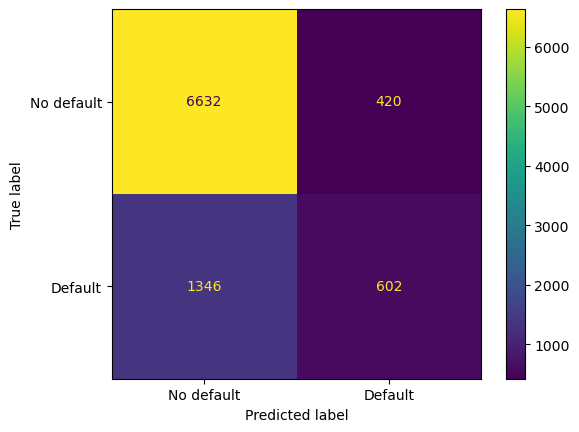

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay  # Recommended method in sklearn 1.0

cm = ConfusionMatrixDisplay.from_estimator(
    pipe_rf, X_test_new, y_test, values_format="d", display_labels=["No default", "Default"]
)

<div class="alert alert-warning">
    
Solution_13
    
</div>

_Points:_ 12

| Model               | Train Accuracy | Test Accuracy | Fit Time (s) | Best Parameters                                     | Recall   | F1 Score |
|--------------------|----------------|---------------|--------------|-----------------------------------------------------|----------|----------|
| LogisticRegression | 0.8031         | 0.8033        | ~0.012       | `C = 0.075`                                          | 0.2423   | 0.3467   |
| RandomForest       | 0.8091         | 0.8036        | ~2.200       | `n_estimators = 110`, `max_depth = 5`               | 0.3147   | 0.4109   |
| KNN                | 0.8137         | 0.7994        | ~0.009       | `n_neighbors = 17`                                  | 0.3054   | 0.3934   |
| SVC                | 0.8076         | 0.8022        | ~3.4         | `C = 4`, `gamma = 0.15`                              | 0.3034   | 0.3991   |

After hyperparameter optimization, all models showed improvement, but Logistic Regression and Random Forest remained the top performers in terms of test accuracy. Logistic Regression was slightly more efficient, with faster training time and marginally better generalization, making it a strong candidate for production if interpretability and speed are priorities.

In terms of recall and F1 score, LogisticRegression had the worst performance overall while RandomForest had the best performance overall. However, the recall scores are quite low for all models suggesting that the positive class is underrepresented (class imbalance). 


Random Forest provided valuable insights into feature importance, revealing that the most predictive feature was NUM_LATE_PAYMENTS, followed by TOTAL_PAY and UTIL_RATE.

Other ideas that could potentially improve the performance/interpretability include:
- Try more advanced hyperparameter tuning (ex. Bayesian optimization for finer search) so we could get more precise hyperparameter optimization
- Try Gradient Boosting (e.g. XGBoost or LightGBM) which typically perform better than random forests
- Add class_weight as a parameter to increase recall score (ie, making the model more sensitive to the positive classes)
- Use SMOTE to balance the class distribution to improve the recall scores
- Try doing more threshold tuning in the models to increase recall scores


The best-performing model was the Random Forest, with a final test accuracy of 0.8036 and F1 score of 0.4109. Accuracy was used as our evaluation metric.